<a href="https://colab.research.google.com/github/Shalaka003/CDPR-Sentiment-Analysis/blob/main/Image_Enhancement_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage.filters import uniform_filter

In [ ]:
def get_non_uniform_sampling(source, steps):
    shape = np.shape(source)
    height = shape[0]
    length = shape[1]
    
    x_centre = int(length/2)
    y_centre = int(height/2)
    radius = int(min(length, height)/2)
    
    pi = np.pi
    multiplier = 0.5
    x_coordinates = []
    y_coordinates = []

    for r in steps:
        number_of_points = (1/multiplier) * 2

        for j in range(int(number_of_points)):
            theta = j*pi*multiplier
            x = x_centre + (r * np.cos(theta))
            y = y_centre + (r * np.sin(theta))
            
            if(x<length and x>0 and y<height and y>0):
                x_coordinates.append(int(x))
                y_coordinates.append(int(y))

        multiplier = multiplier/2
    
    return x_coordinates, y_coordinates


def window_stdev(X, window_size):
    c1 = uniform_filter(X, window_size, mode='reflect')
    c2 = uniform_filter(X*X, window_size, mode='reflect')
    return np.sqrt(c2 - c1*c1)

In [ ]:
img = cv2.imread("/content/image081.png")
print(np.shape(img))
(B,G,R) = cv2.split(img)
#cv2.imshow("Source Image", img)
#cv2.waitKey(0)

(1152, 1500, 3)


In [ ]:
steps = [40, 150, 370, 560, 700]
x_coordinates, y_coordinates = get_non_uniform_sampling(G, steps)
number_of_points = (np.shape(x_coordinates))[0]
print("The number of points is", number_of_points)

The number of points is 98


Text(0.5, 1.0, 'Image and Sampling Points')

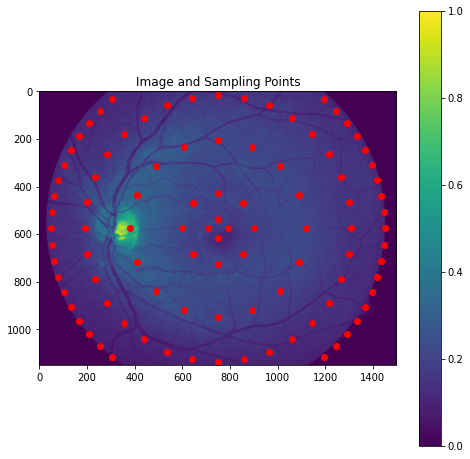

In [ ]:
plt.figure(figsize = (8,8))
plt.imshow(G)
plt.scatter(x_coordinates, y_coordinates, color='red')
plt.colorbar()
plt.title("Image and Sampling Points")

In [ ]:
def get_roi_values(src, x , y, window_size):
    height = np.shape(img)[0]
    length = np.shape(img)[1]
    
    left = x - int(window_size/2)
    left = max(0, left)
    
    right = x + int(window_size/2)
    right = min(length, right)
    
    top = y - int(window_size/2)
    top = max(0, top)
    
    bottom = y + int(window_size/2)
    bottom = min(height, bottom)
    
    slice_arr = src[top:bottom, left:right]
    
    return slice_arr, np.mean(slice_arr), np.std(slice_arr)

def get_mean_std(src, x_coordinates, y_coordinates, window_size):
    mean = []
    std = []
    number_of_points = np.shape(x_coordinates)[0]
    
    for i in range(number_of_points):
        slice_arr, slice_mean, slice_std = get_roi_values(src, x_coordinates[i], y_coordinates[i], window_size)
        mean.append(slice_mean)
        std.append(slice_std)
    
    return mean, std

In [ ]:
mean, std = get_mean_std(G, x_coordinates, y_coordinates, 50)

In [ ]:
# image_window_size = 50
# G_mean = cv2.blur(G, (image_window_size, image_window_size))
# G_mean = np.array(G_mean, dtype=np.float32)

# plt.figure(figsize = (8,8))
# plt.imshow(G_mean)
# plt.colorbar()
# plt.title("Mean of Image")

In [ ]:
# G_std = window_stdev(G, image_window_size)
# G_std = np.array(G_std, dtype=np.float32)

# plt.figure(figsize = (8,8))
# plt.imshow(G_std)
# plt.colorbar()
# plt.title("Standard Deviation of Image")

In [ ]:
# mean = np.empty(number_of_points)
# std = np.empty(number_of_points)

# for i in range(number_of_points):
#     x = x_coordinates[i]
#     y = y_coordinates[i]
    
#     mean[i] = G_mean[y, x]
#     std[i] = G_std[y, x]

In [ ]:
xi = np.arange(0, np.shape(G)[1], 1)
yi = np.arange(0, np.shape(G)[0], 1)
x_grid, y_grid = np.meshgrid(xi, yi)

points = []
for i , j in zip(x_coordinates, y_coordinates):
    points.append([i,j])

Text(0.5, 1.0, 'Interpolated Mean')

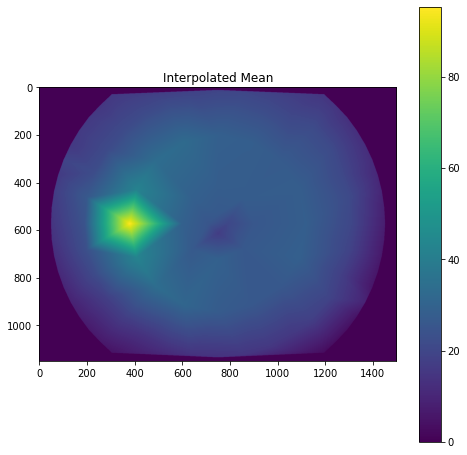

In [ ]:
interpolated_mean = scipy.interpolate.griddata(points, mean, (x_grid, y_grid) , method='linear', fill_value=0, rescale=False)

plt.figure(figsize = (8,8))
plt.imshow(interpolated_mean)
plt.colorbar()
plt.title("Interpolated Mean")

Text(0.5, 1.0, 'Interpolated Standard Deviation')

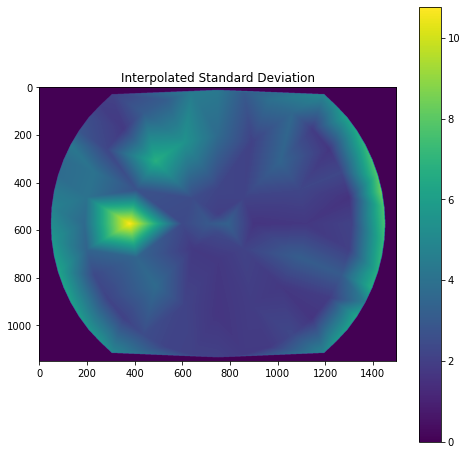

In [ ]:
interpolated_std = scipy.interpolate.griddata(points, std, (x_grid, y_grid) , method='linear', fill_value=0, rescale=False)

plt.figure(figsize = (8,8))
plt.imshow(interpolated_std)
plt.colorbar()
plt.title("Interpolated Standard Deviation")

<ipython-input-14-1d2efea2735a>:11: RuntimeWarning: divide by zero encountered in true_divide
  mahalanobis = np.abs((G - interpolated_mean)/interpolated_std)
<ipython-input-14-1d2efea2735a>:11: RuntimeWarning: invalid value encountered in true_divide
  mahalanobis = np.abs((G - interpolated_mean)/interpolated_std)


Text(0.5, 1.0, 'Mahalanobis Distance')

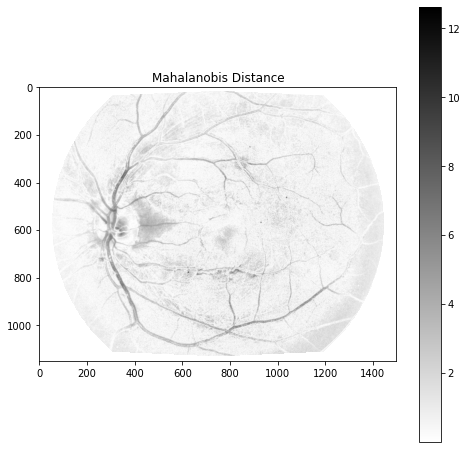

In [ ]:
height = np.shape(G)[0]
length = np.shape(G)[1]

mahalanobis = np.empty(np.shape(G))
background = np.zeros(np.shape(G))

G = np.array(G)
interpolated_mean = np.array(interpolated_mean)
interpolated_std = np.array(interpolated_std)

mahalanobis = np.abs((G - interpolated_mean)/interpolated_std)
plt.figure(figsize = (8,8))
plt.imshow(mahalanobis, cmap='binary')
plt.colorbar()
plt.title("Mahalanobis Distance")

In [ ]:
for i in range(height):
    for j in range(length):
        if(mahalanobis[i, j] <= 1):
            background[i, j] = 1

Text(0.5, 1.0, 'Background')

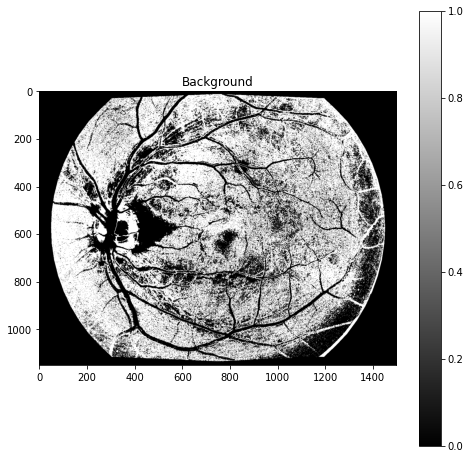

In [ ]:
plt.figure(figsize = (8,8))
plt.imshow(background, cmap="binary_r")
plt.colorbar()
plt.title("Background")

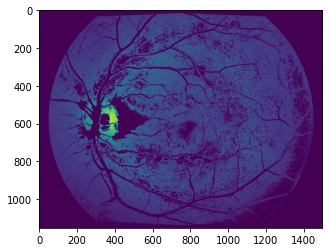

In [ ]:
background = np.array(background)
G = np.array(G)

mult = background*G
plt.imshow(mult)

In [ ]:
x_white = np.where(background==1)[1]
y_white = np.where(background==1)[0]

In [ ]:
# background_window_size = 125
# SA = cv2.blur(background, (background_window_size, background_window_size))
# SM = window_stdev(background, background_window_size)

In [ ]:
print(np.shape(x_white)[0])

855340


In [ ]:
mean_mult = []
std_mult = []
number_of_points = np.shape(x_white)[0]
window_size =125
  
for i in range(number_of_points):
    mult_slice, temp_mean, temp_std = get_roi_values(mult, x_white[i] , y_white[i], window_size)
    mult_slice = mult_slice[mult_slice != 0]
    mean_m = np.mean(mult_slice)
    std_m = np.std(mult_slice)
    mean_mult.append(mean_m)
    std_mult.append(std_m)


print(mean_mult)
print(std_mult)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
points_bg = []
for i , j in zip(x_white, y_white):
    points_bg.append([i,j])

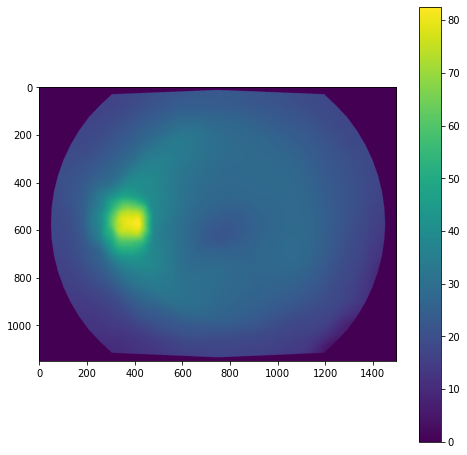

In [23]:
interpolated_meanmult = scipy.interpolate.griddata(points_bg, mean_mult, (x_grid, y_grid) , method='linear', fill_value=0, rescale=False)

plt.figure(figsize = (8,8))
plt.imshow(interpolated_meanmult)
plt.colorbar()

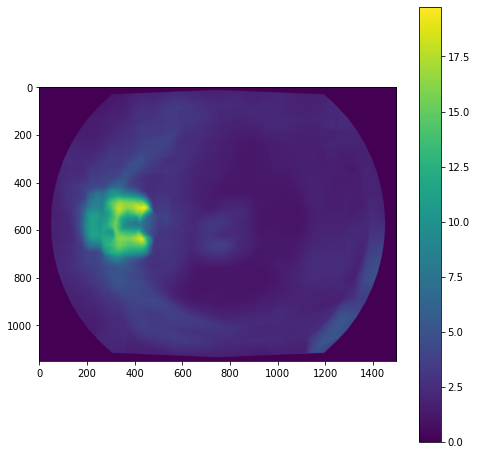

In [24]:
interpolated_stdmult = scipy.interpolate.griddata(points_bg, std_mult, (x_grid, y_grid) , method='linear', fill_value=0, rescale=False)

plt.figure(figsize = (8,8))
plt.imshow(interpolated_stdmult)
plt.colorbar()

In [ ]:
# background_window_size = 25
# SA, SM = get_mean_std(G, x_white, y_white, background_window_size)


In [ ]:
# plt.figure(figsize = (8,8))
# plt.imshow(SA)
# plt.colorbar()
# plt.title("SA")

In [ ]:
# plt.figure(figsize = (8,8))
# plt.imshow(SM)
# plt.colorbar()
# plt.title("SM")

In [25]:
U = np.empty(np.shape(G))
G= np.array(G)
SM = np.array(interpolated_stdmult)
SA = np.array(interpolated_meanmult)
# for i in range(height):
#     for j in range(length):
#         U[i, j] = (G[i, j] - SA[i, j])/SM[i, j]

U = (G - SA) / SM

<ipython-input-25-8af1b2bec602>:9: RuntimeWarning: divide by zero encountered in true_divide
  U = (G - SA) / SM
<ipython-input-25-8af1b2bec602>:9: RuntimeWarning: invalid value encountered in true_divide
  U = (G - SA) / SM


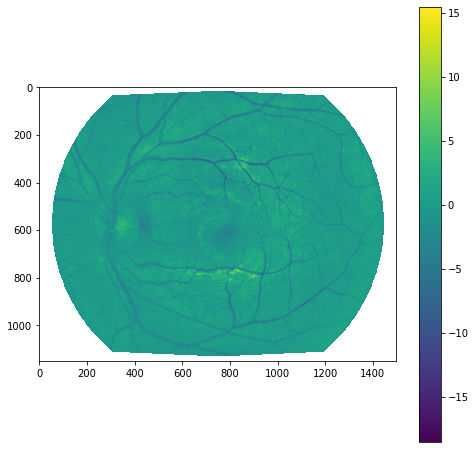

In [26]:
plt.figure(figsize = (8,8))
plt.imshow(U)
plt.colorbar()
#plt.clim(0, 0.25000000e+11);

<ipython-input-32-50215ff8260f>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_corr = (U/v)*R
<ipython-input-32-50215ff8260f>:16: RuntimeWarning: invalid value encountered in multiply
  R_corr = (U/v)*R
<ipython-input-32-50215ff8260f>:17: RuntimeWarning: divide by zero encountered in true_divide
  G_corr = (U/v)*G
<ipython-input-32-50215ff8260f>:17: RuntimeWarning: invalid value encountered in multiply
  G_corr = (U/v)*G
<ipython-input-32-50215ff8260f>:18: RuntimeWarning: divide by zero encountered in true_divide
  B_corr = (U/v)*B
<ipython-input-32-50215ff8260f>:18: RuntimeWarning: invalid value encountered in multiply
  B_corr = (U/v)*B


Text(0.5, 1.0, 'B plane')

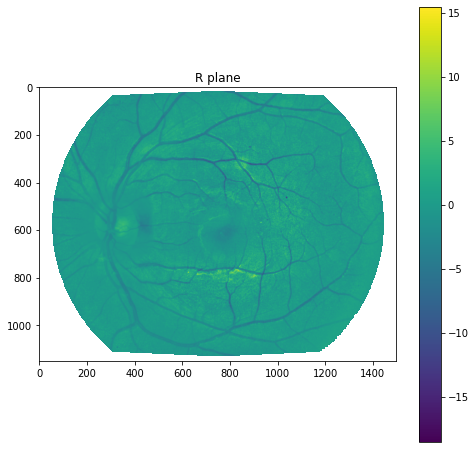

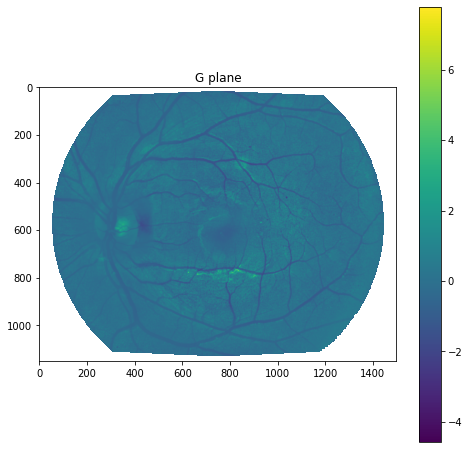

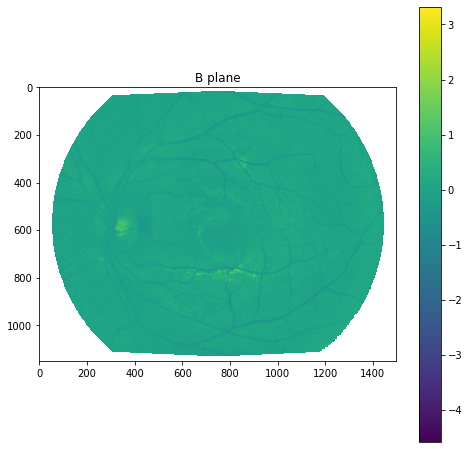

In [32]:
v = np.empty(np.shape(G))
R = np.array(R)
G = np.array(G)
B = np.array(B)

# for i in range(height):
#     for j in range(length):
#       if((R[i,j] >= G[i,j]) and (R[i,j] >= B[i,j])):
#         v[i, j]= R[i,j]
#       elif(G[i,j] >= B[i,j]):
#         v[i,j] = G[i,j]
#       else:
#         v[i,j] = B[i,j]

v= np.maximum(np.maximum(R,G),B)
R_corr = (U/v)*R
G_corr = (U/v)*G
B_corr = (U/v)*B

plt.figure(figsize = (8,8))
plt.imshow(R_corr)
plt.colorbar()
plt.title("R plane")

plt.figure(figsize = (8,8))
plt.imshow(G_corr)
plt.colorbar()
plt.title("G plane")

plt.figure(figsize = (8,8))
plt.imshow(B_corr)
plt.colorbar()
plt.title("B plane")

In [33]:
# Final_image = R_corr + G_corr + B_corr
Final_image = np.dstack((R_corr,G_corr,B_corr))

Text(0.5, 1.0, 'Finale')

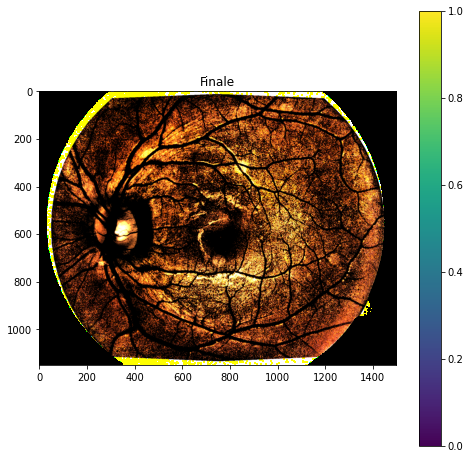

In [34]:
plt.figure(figsize = (8,8))
plt.imshow(Final_image)
plt.colorbar()
plt.title("Finale")